Добый день! Спасибо за внимание к моему резюме.

Я не успела построить прогноз по всем категориям товаров, сосредоточилась на одном (аналигетиках), однако, алгоритм действий для других категорий такой же.

Данные из таблицы **ana_sales_data.parquet**:
- `upc` - товар
- `store` - магазин
- `week` - неделя (номер)
- `move` - количество покупок за неделю (в одной покупке может быть несколько единиц товара)
- `price` - цена покупки 
- `qty` - количество единиц товара в покупке
- `sale` - распродажи ('B' - бонус, 'C' - купон, 'S' - скидка)

Отдельно хочу обратить внимание на признаки `move`, `price` и `qty`. Из этих признаков я получила два других, как мне кажется более подходящих:
- `price_per_item` - цена за единицу товара (`price / qty`)
- `num_items_sold` - количество проданных единиц товара (`move * qty`)

In [1]:
import numpy as np
import pandas as pd

import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (mean_absolute_error, root_mean_squared_error,
                             mean_absolute_percentage_error)

from prophet import Prophet
from catboost import CatBoostRegressor

## Анализ данных

In [2]:
ana_sales_df = pd.read_parquet('data/ana_sales_data.parquet')
ana_sales_df

,store,upc,week,move,qty,price,sale
0,76,1192603016,306,0,1,0.00,None
1,76,1192603016,307,1,1,2.99,None
2,76,1192603016,308,0,1,0.00,None
3,76,1192603016,309,0,1,0.00,None
4,76,1192603016,310,0,1,0.00,None
...,...,...,...,...,...,...,...
7339212,144,78765150152,395,0,1,0.00,None
7339213,144,78765150152,396,0,1,0.00,None
7339214,144,78765150152,397,0,1,0.00,None
7339215,144,78765150152,398,0,1,0.00,None


In [3]:
print('Процент пропущенных значений:')
((ana_sales_df.isna().sum() / len(ana_sales_df)) * 100).sort_values(ascending=False)

Процент пропущенных значений:


sale     96.373439
store     0.000000
upc       0.000000
week      0.000000
move      0.000000
qty       0.000000
price     0.000000
dtype: float64

In [4]:
print('Дубликаты в данных:')
ana_sales_df.duplicated().sum()

Дубликаты в данных:


0

In [5]:
print('Количество уникальных значений признаков (включая пропуски):')
ana_sales_df.nunique(dropna=False)

Количество уникальных значений признаков (включая пропуски):


store      93
upc       641
week      392
move      172
qty         1
price    1152
sale        5
dtype: int64

`sale` - код распродажи (B,C,S). Эта переменная указывает, продавался ли товар по акции на этой неделе. Код «B» указывает на бонусную покупку, «C» - на купон, «S» - на простое снижение цены.

In [6]:
ana_sales_df['sale'].value_counts(dropna=False)

sale
None    6979032
B        220616
S         39388
C          2232
G           387
Name: count, dtype: int64

В признаке `sale` присутствует небольшое количество строк со значением «G» (387). Вероятно, это опечатка. Удалим эти строки из тренировочного датасета.

`None` в признаке `sale` говорит о том, что покупка была совершена без скидок, бонусов и купонов. Заменим пропуски на «N».

In [7]:
ana_sales_df['sale'] = ana_sales_df['sale'].fillna('N')

Вместо номера недели генерируем признак с датой `date`.

In [8]:
start_date = datetime.date(1989, 9, 14)

ana_sales_df['date'] = ana_sales_df['week'].apply(\
                            lambda x: start_date + datetime.timedelta(7 * (x - 1)))
ana_sales_df['date'] = pd.to_datetime(ana_sales_df['date'])

Добавим необходимые для анализа данные:
- `price_per_item` - цена за единицу товара;
- `num_items_sold` - количество проданных единиц товара.

In [9]:
ana_sales_df['price_per_item'] = ana_sales_df['price'] / ana_sales_df['qty']
ana_sales_df['num_items_sold'] = ana_sales_df['move'] * ana_sales_df['qty']

Выделим в отдельный датасет данные, где была совершена хотя бы одна покупка за неделю.

In [10]:
ana_purchase_df = ana_sales_df[ana_sales_df['move'] != 0]
ana_purchase_df

,store,upc,week,move,qty,price,sale,date,price_per_item,num_items_sold
1,76,1192603016,307,1,1,2.99,N,1995-07-27,2.99,1
66,71,1192662108,286,1,1,4.49,N,1995-03-02,4.49,1
152,98,1192662108,286,2,1,4.49,N,1995-03-02,4.49,2
240,101,1192662108,288,1,1,4.49,N,1995-03-16,4.49,1
324,121,1192662108,286,2,1,4.49,N,1995-03-02,4.49,2
...,...,...,...,...,...,...,...,...,...,...
7339147,143,78765142067,384,1,1,7.49,N,1997-01-16,7.49,1
7339163,146,78765142067,384,1,1,7.49,N,1997-01-16,7.49,1
7339169,146,78765142067,390,1,1,7.49,N,1997-02-27,7.49,1
7339178,146,78765142067,399,1,1,7.49,N,1997-05-01,7.49,1


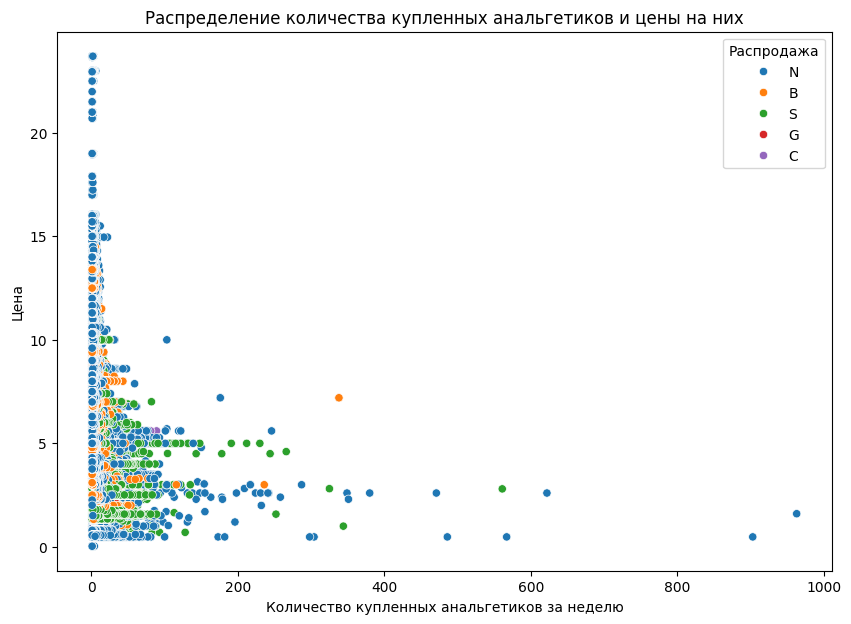

In [11]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=ana_purchase_df, x='num_items_sold', y='price_per_item', hue='sale');
plt.title('Распределение количества купленных анальгетиков и цены на них')
plt.xlabel('Количество купленных анальгетиков за неделю')
plt.ylabel('Цена')
plt.legend(title='Распродажа', loc='upper right');

На графике видны аномально большие значения количества покупок. Возможно, это выбросы.

In [12]:
ana_sales_df.sort_values('num_items_sold', ascending=False).head(10)

,store,upc,week,move,qty,price,sale,date,price_per_item,num_items_sold
149717,98,3828161001,22,963,1,1.59,N,1990-02-08,1.59,963
2062606,98,30045046807,47,903,1,0.47,N,1990-08-02,0.47,903
161004,132,3828161001,366,622,1,2.59,N,1996-09-12,2.59,622
2062508,92,30045046807,47,567,1,0.47,N,1990-08-02,0.47,567
2099063,68,30045046845,213,561,1,2.79,S,1993-10-07,2.79,561
2062509,92,30045046807,48,486,1,0.47,N,1990-08-09,0.47,486
161005,132,3828161001,367,471,1,2.59,N,1996-09-19,2.59,471
161093,133,3828161001,128,380,1,2.59,N,1992-02-20,2.59,380
161777,136,3828161001,107,351,1,2.29,N,1991-09-26,2.29,351
161092,133,3828161001,127,349,1,2.59,N,1992-02-13,2.59,349


In [13]:
print('Средняя цена товара в порядке убывания:')
ana_purchase_df.groupby('upc').agg({'price_per_item': 'mean'}).sort_values(by='price_per_item', ascending=False)

Средняя цена товара в порядке убывания:


,price_per_item
upc,
34153300318,23.675103
34153300316,22.885141
7498009700,22.672240
34153300320,20.899559
34153300314,18.957524
...,...
30045046706,0.470000
30009348105,0.470000
30009346301,0.470000


Высокие цены, которые видны на графике, выбросами не являются, это просто дорогие товары.

### Кривая эластичности

Разделим данные по группам цен для построения кривой эластичности:
- цена до 5 за единицу товара;
- от 5 до 10;
- от 10 до 15;
- и так далее с шагом 5.

После сгруппируем данные и вычислим количество купленных единиц товара за цену, вхлдящую в каждую группу.

In [14]:
step = 5
ana_sales_df['price_group'] = ana_sales_df['price_per_item'] // step * step + step
ana_agg_df = ana_sales_df.groupby('price_group', as_index=False).agg({'num_items_sold': 'sum'})
ana_agg_df

,price_group,num_items_sold
0,5.0,5117592
1,10.0,2697721
2,15.0,205328
3,20.0,11715
4,25.0,1291


По получившимся данным построем кривую эластичности.

In [15]:
def elasticity_curve(price, demand):
    price = price.to_numpy()
    demand = demand.to_numpy()

    # изменения цены и спроса
    delta_price = np.diff(price)
    delta_demand = np.diff(demand)

    # процентные изменения
    percent_change_price = delta_price / price[:-1]
    percent_change_demand = delta_demand / demand[:-1]

    # эластичность спроса по цене
    elasticity = percent_change_demand / percent_change_price

    # центры интервалов цен для графика
    price_midpoints = (price[:-1] + price[1:]) / 2

    # кривая эластичности
    plt.figure(figsize=(8, 5))
    
    plt.plot(price_midpoints, elasticity, marker='o', label='Эластичность спроса')

    plt.title("Кривая эластичности спроса")
    plt.xlabel("Цена")
    plt.ylabel("Эластичность")
    plt.legend()
    plt.show()


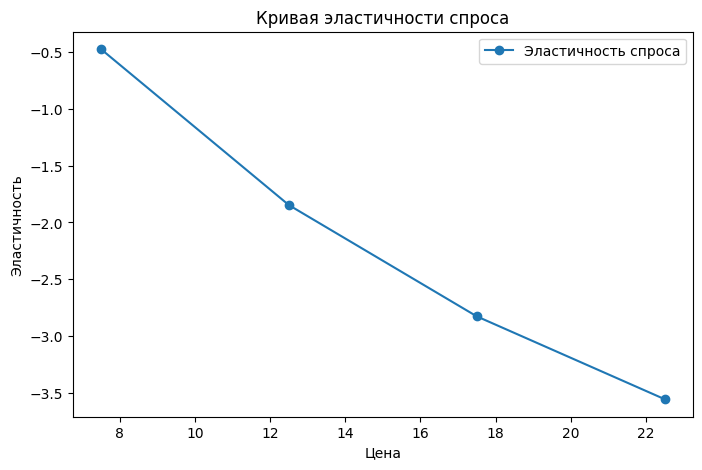

In [16]:
elasticity_curve(ana_agg_df['price_group'], ana_agg_df['num_items_sold'])

### Декомпозиция ряда

In [17]:
ana_grouped_df = ana_sales_df.groupby('date').agg({'num_items_sold': 'sum'})

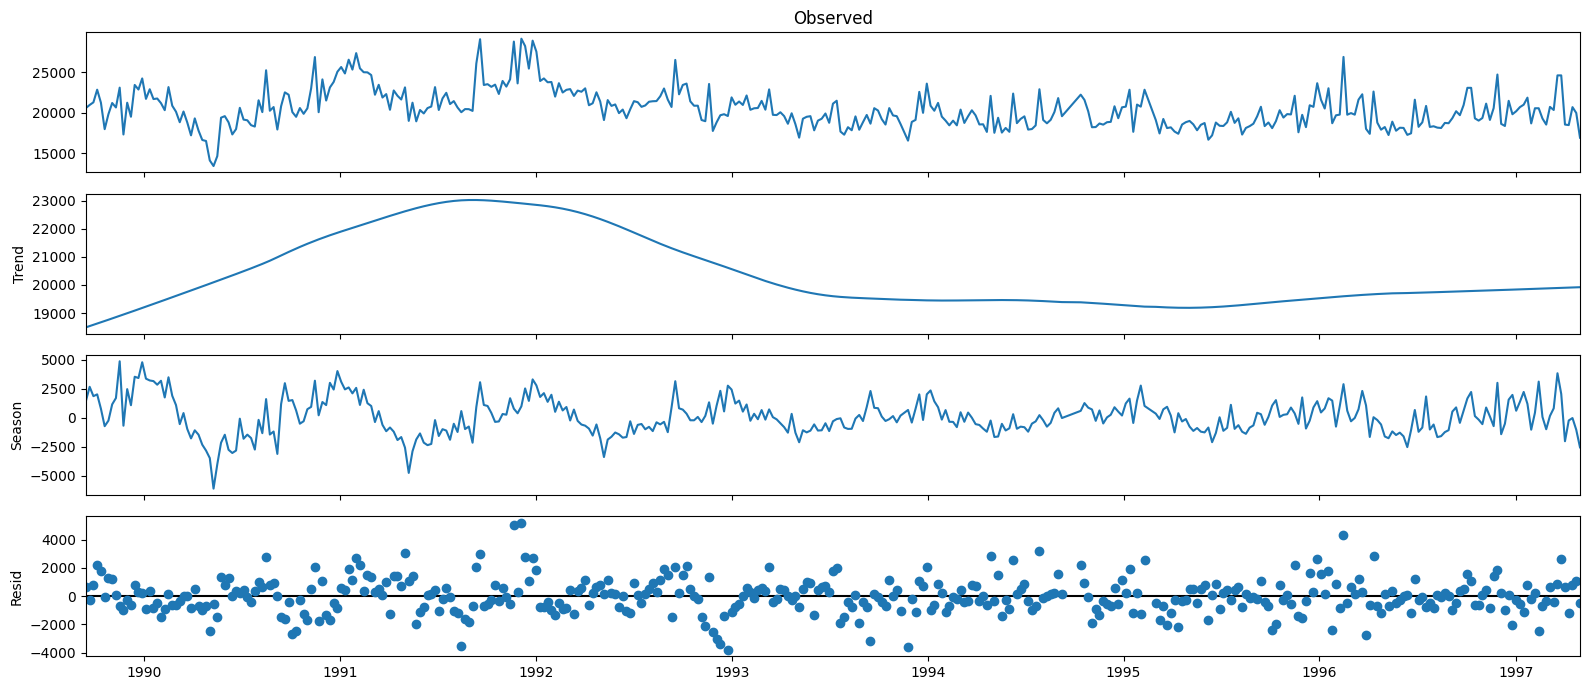

In [18]:
plt.rcParams['figure.figsize'] = [16, 7]
result = STL(ana_grouped_df, period=52).fit()  # 52 недели в году
result.plot();

Видим повышенный тренд в 1991-1993 годах, а также сезонные колебания до 1993 года, где пики приходятся на осенне-зимний период.

### Стационарность

Проверим ряд на стационарность расширенным тестом Дики-Фуллера (Augmented Dickey-Fuller Test).
- H0: ряд нестационарен 
- H1: ряд стационарен

In [19]:
adf = adfuller(ana_grouped_df['num_items_sold'])

print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print('Critical Values:')
for key, value in adf[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -4.114419596718909
p-value: 0.0009167148049831462
Critical Values:
   1%: -3.4473167281607155
   5%: -2.869018036958473
   10%: -2.5707536074503134


**p-value < 0.05** -> нулевую гипотезу можно отвергнуть. Принимаем альтернативную гипотезу, что ряд стационарен.

### Итог по данным:
- в признаке `sale` есть некорректные значения «G»;
- наблюдаюся аномально большие значения в признаке `num_items_sold`;
- `num_items_sold` - целевая переменная, которую необходимо предсказывать;
- p_value < 0.05 (ADF) - ряд стационарен.

## Feature engineering

Разделим датасет на тренировночную и тестовую выборки. В тестовую выборку пойдут данные за последний год, все остальные - в тренировочную.

In [20]:
test_start = ana_sales_df['date'].max() - relativedelta(years=1)

train = ana_sales_df[ana_sales_df['date'] < test_start]
test = ana_sales_df[ana_sales_df['date'] >= test_start]

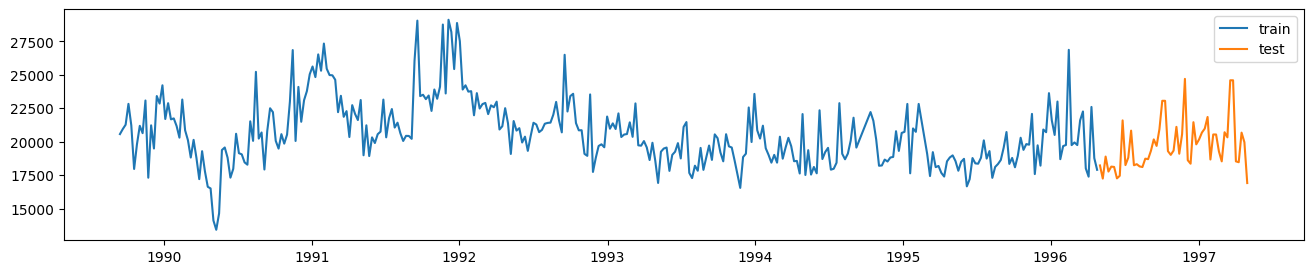

In [21]:
plt.figure(figsize=(16, 3))

plt.plot(train.groupby('date').agg({'num_items_sold': 'sum'}), label='train')
plt.plot(test.groupby('date').agg({'num_items_sold': 'sum'}), label='test')
plt.legend();

Удалим аномальные значения в признаке `move` из тренировочной выборки.

In [22]:
train = train[train['num_items_sold'] <= 400]

Удалим некорректные значения в признаке `sale`.

In [23]:
train = train[train['sale'] != 'G']

Закодируем признак `sale`.

In [24]:
ohe = OneHotEncoder(sparse_output=False, dtype='int8', handle_unknown='ignore', drop=['N'])
ohe.fit(train[['sale']])

OneHotEncoder(drop=['N'], dtype='int8', handle_unknown='ignore',
              sparse_output=False)

In [25]:
train[ohe.get_feature_names_out()] = ohe.transform(train[['sale']])
train.head()

,store,upc,week,move,qty,price,sale,date,price_per_item,num_items_sold,price_group,sale_B,sale_C,sale_S
0,76,1192603016,306,0,1,0.00,N,1995-07-20,0.00,0,5.0,0,0,0
1,76,1192603016,307,1,1,2.99,N,1995-07-27,2.99,1,5.0,0,0,0
2,76,1192603016,308,0,1,0.00,N,1995-08-03,0.00,0,5.0,0,0,0
3,76,1192603016,309,0,1,0.00,N,1995-08-10,0.00,0,5.0,0,0,0
4,76,1192603016,310,0,1,0.00,N,1995-08-17,0.00,0,5.0,0,0,0


Сгруппируем данные по дате.

In [26]:
agg_data = {
    'price_per_item': 'mean',
    **{col: 'sum' for col in ('sale_B', 'sale_C', 'sale_S', 'num_items_sold')}
}

train = train.groupby('date').agg(agg_data).reset_index()
train.head()

,date,price_per_item,sale_B,sale_C,sale_S,num_items_sold
0,1989-09-14,2.146994,977,0,233,20570
1,1989-09-21,2.203662,243,0,0,20946
2,1989-09-28,2.164980,375,0,67,21270
3,1989-10-05,2.180599,440,0,135,22829
4,1989-10-12,2.113397,723,0,279,21226


Добавим признак `day_of_year` - порядковый номер дня в году.

In [27]:
train['day_of_year'] = train['date'].dt.day_of_year

Добавим лаги.

In [28]:
lag_num = 7
for lag in range(1, lag_num + 1):  # лаги за lag_num предыдущих недель
    train[f'lag_{lag}'] = train['num_items_sold'].shift(lag)

# Удаляем пропущенные значения (после создания лагов)
train = train.dropna()

Скалируем данные.

In [29]:
columns_for_scale = train.columns.drop(['date', 'num_items_sold'])

scaler = StandardScaler()
scaler.fit(train[columns_for_scale])

StandardScaler()

In [30]:
train[columns_for_scale] = scaler.transform(train[columns_for_scale])

Переименуем признаки: `date` в `ds`, `num_items_sold` в `y`. Это нужно для модели `Prophet`.

In [31]:
train = train.rename(columns={'date': 'ds', 'num_items_sold': 'y'})
train.head()

,ds,price_per_item,sale_B,sale_C,sale_S,y,day_of_year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,1989-11-02,0.158891,0.394807,-0.158177,0.107026,21187,1.159446,-0.323177,-1.073471,0.255908,0.902982,0.263920,0.133345,-0.019005
8,1989-11-09,-0.069705,-0.478092,-0.158177,0.098325,20638,1.224217,0.237355,-0.321890,-1.072753,0.249572,0.900418,0.265711,0.134642
9,1989-11-16,0.323425,0.719483,-0.158177,-0.797819,23081,1.288989,0.013875,0.238135,-0.320496,-1.080890,0.245956,0.902622,0.267040
10,1989-11-23,-0.757015,0.833918,-0.158177,2.334335,17308,1.353760,1.008340,0.014857,0.240032,-0.327614,-1.086647,0.247735,0.904105
11,1989-11-30,-0.035744,0.450694,-0.158177,-0.797819,21224,1.418531,-1.341660,1.008423,0.016554,0.233675,-0.332158,-1.085734,0.249060


Аналогично подготовим тестовые данные (кроме аномальных и некорректных значений).

In [ ]:
# закодируем признак `sale`
test[ohe.get_feature_names_out()] = ohe.transform(test[['sale']])
# сгруппируем данные по дате
test = test.groupby('date').agg(agg_data).reset_index()
# добавим признак `day_of_year` - порядковый номер дня в году
test['day_of_year'] = test['date'].dt.day_of_year
# добавим лаги
for lag in range(1, lag_num + 1):  # лаги за lag_num предыдущих недель
    test[f'lag_{lag}'] = test['num_items_sold'].shift(lag)
    test[f'lag_{lag}'].iloc[:lag] = train['y'].iloc[-lag:]
# скалируем данные
test[columns_for_scale] = scaler.transform(test[columns_for_scale])
# переименуем признаки: `date` в `ds`, `num_items_sold` в `y`
test = test.rename(columns={'date': 'ds', 'num_items_sold': 'y'})

In [33]:
test.head()

,ds,price_per_item,sale_B,sale_C,sale_S,y,day_of_year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,1996-05-02,-0.904059,0.538516,-0.158177,-0.145287,18226,-0.533862,-1.101490,-0.743231,0.814808,-1.315677,-1.069908,0.670981,0.401073
1,1996-05-09,-1.000457,0.434726,-0.158177,0.533347,17242,-0.469091,-0.967972,-1.099499,-0.742216,0.809230,-1.321812,-1.068984,0.672408
2,1996-05-16,-0.655273,-0.589866,-0.158177,1.638301,18888,-0.404319,-1.368527,-0.966102,-1.098805,-0.749905,0.806515,-1.321052,-1.067976
3,1996-05-23,-0.506232,-0.539302,-0.158177,-0.153987,17768,-0.339548,-0.698493,-1.366294,-0.965287,-1.106977,-0.755129,0.808659,-1.320105
4,1996-05-30,-0.882858,0.197873,-0.158177,0.959667,18138,-0.274777,-1.154409,-0.696867,-1.365840,-0.973279,-1.112777,-0.754001,0.810119


## Modeling

In [34]:
# датасет для хранения метрик различных моделей
models_df = pd.DataFrame(columns=['RMSE', 'MAE', 'MAPE'])
models_df

,RMSE,MAE,MAPE


### Prophet

In [35]:
regressors = train.columns.drop(['ds', 'y'])

prophet_model = Prophet()

# добавление регрессоров
for reg in regressors:
    prophet_model.add_regressor(reg)

prophet_model.fit(train)

00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:16 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
prophet_forecast = prophet_model.predict(test.drop(columns=['y']))

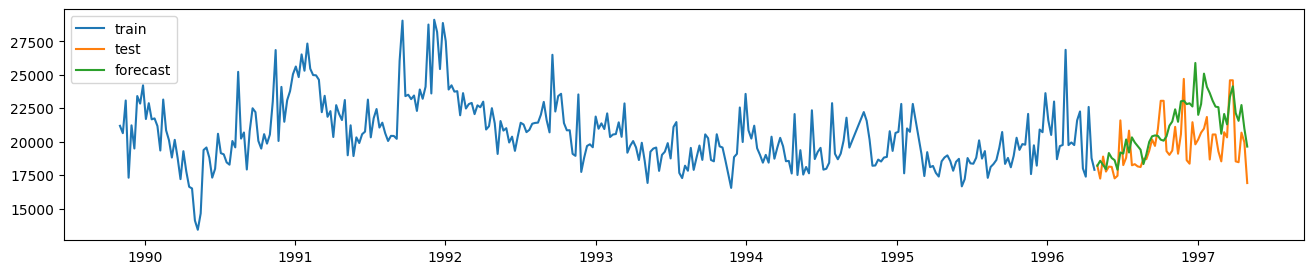

In [37]:
plt.figure(figsize=(16, 3))

plt.plot(train[['ds', 'y']].set_index('ds'), label='train')
plt.plot(test[['ds', 'y']].set_index('ds'), label='test')
plt.plot(prophet_forecast[['ds', 'yhat']].set_index('ds'), label='forecast')

plt.legend();

In [38]:
rmse = root_mean_squared_error(test['y'], prophet_forecast['yhat'])
mae = mean_absolute_error(test['y'], prophet_forecast['yhat'])
mape = mean_absolute_percentage_error(test['y'], prophet_forecast['yhat'])

print('RMSE:', rmse)
print('MAE: ', mae)
print('MAPE:', mape)

# добавим метрики в датафрейм
models_df.loc['prophet'] = [rmse, mae, mape]

RMSE: 2258.09592352639
MAE:  1854.4196424343963
MAPE: 0.09443896054926647


### Sarimax

In [39]:
sarimax_model = SARIMAX(endog=train['y'], exog=train[regressors], 
                        seasonal_order=(0, 0, 1, 52))
sarimax_model = sarimax_model.fit()

/home/ei/ML/ml_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ei/ML/ml_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05763D+00    |proj g|=  1.24568D-01

At iterate    5    f=  9.04605D+00    |proj g|=  1.06146D-03

At iterate   10    f=  9.04581D+00    |proj g|=  1.68466D-02

At iterate   15    f=  9.04441D+00    |proj g|=  5.66409D-03

At iterate   20    f=  9.03355D+00    |proj g|=  6.87003D-02

At iterate   25    f=  8.88828D+00    |proj g|=  1.44628D-02

At iterate   30    f=  8.88568D+00    |proj g|=  2.62129D-04

At iterate   35    f=  8.88564D+00    |proj g|=  1.12751D-03

At iterate   40    f=  8.88167D+00    |proj g|=  3.30647D-02

At iterate   45    f=  8.81453D+00    |proj g|=  1.04110D-02

At iterate   50    f=  8.80921D+00    |proj g|=  2.75068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/ei/ML/ml_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
sarimax_forecast = sarimax_model.predict(start=train.shape[0], 
                                         end=train.shape[0] + test.shape[0] - 1,
                                         exog=test[regressors])

/home/ei/ML/ml_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ei/ML/ml_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


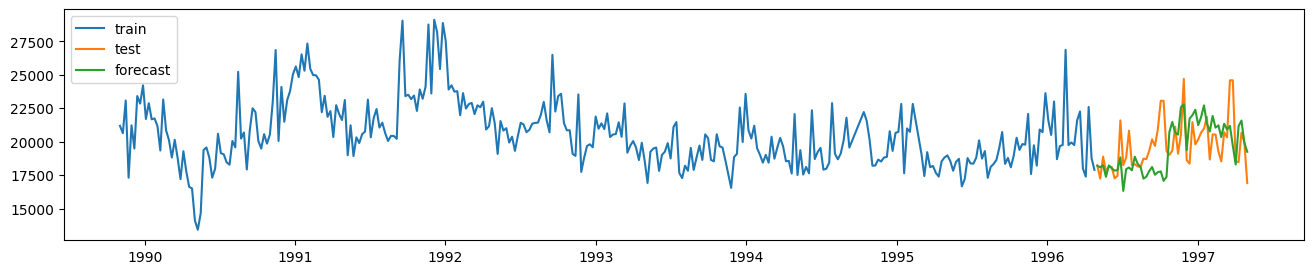

In [41]:
plt.figure(figsize=(16, 3))

plt.plot(train[['ds', 'y']].set_index('ds'), label='train')
plt.plot(test[['ds', 'y']].set_index('ds'), label='test')
plt.plot(test['ds'], sarimax_forecast, label='forecast')

plt.legend();

In [42]:
rmse = root_mean_squared_error(test['y'], sarimax_forecast)
mae = mean_absolute_error(test['y'], sarimax_forecast)
mape = mean_absolute_percentage_error(test['y'], sarimax_forecast)

print('RMSE:', rmse)
print('MAE: ', mae)
print('MAPE:', mape)

# добавим метрики в датафрейм
models_df.loc['sarimax'] = [rmse, mae, mape]

RMSE: 2039.559126798184
MAE:  1552.4798421009905
MAPE: 0.07618343228078198


### CatBoostRegressor

In [43]:
catboost_model = CatBoostRegressor(iterations=1000, 
                                   loss_function='RMSE'
                                   )
catboost_model.fit(train.drop(columns=['y']), train['y'])

Learning rate set to 0.034397
0:	learn: 2422.4439527	total: 51.9ms	remaining: 51.9s
1:	learn: 2387.0670398	total: 53.9ms	remaining: 26.9s
2:	learn: 2351.9695626	total: 56.5ms	remaining: 18.8s
3:	learn: 2314.5408956	total: 58.1ms	remaining: 14.5s
4:	learn: 2279.0486540	total: 59.5ms	remaining: 11.8s
5:	learn: 2246.4773753	total: 61ms	remaining: 10.1s
6:	learn: 2213.5132831	total: 62.2ms	remaining: 8.82s
7:	learn: 2183.9790311	total: 63.4ms	remaining: 7.86s
8:	learn: 2155.8319384	total: 64.9ms	remaining: 7.15s
9:	learn: 2127.8770940	total: 66.5ms	remaining: 6.58s
10:	learn: 2099.3384960	total: 68ms	remaining: 6.12s
11:	learn: 2070.0274219	total: 70.2ms	remaining: 5.78s
12:	learn: 2042.5016359	total: 72.5ms	remaining: 5.5s
13:	learn: 2020.4848507	total: 74ms	remaining: 5.21s
14:	learn: 1995.1791821	total: 75.4ms	remaining: 4.95s
15:	learn: 1971.9961220	total: 76.6ms	remaining: 4.71s
16:	learn: 1949.6373440	total: 78ms	remaining: 4.51s
17:	learn: 1926.9589540	total: 79.3ms	remaining: 4.33s

In [44]:
catboost_forecast = catboost_model.predict(test.drop(columns=['y']))

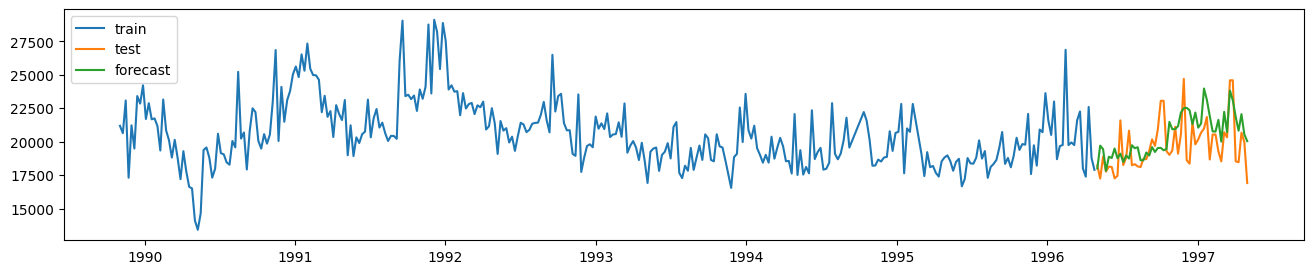

In [45]:
plt.figure(figsize=(16, 3))

plt.plot(train[['ds', 'y']].set_index('ds'), label='train')
plt.plot(test[['ds', 'y']].set_index('ds'), label='test')
plt.plot(test['ds'], catboost_forecast, label='forecast')

plt.legend();

In [46]:
rmse = root_mean_squared_error(test['y'], catboost_forecast)
mae = mean_absolute_error(test['y'], catboost_forecast)
mape = mean_absolute_percentage_error(test['y'], catboost_forecast)

print('RMSE:', rmse)
print('MAE: ', mae)
print('MAPE:', mape)

# добавим метрики в датафрейм
models_df.loc['catboost'] = [rmse, mae, mape]

RMSE: 1849.0705487290506
MAE:  1461.9830386307253
MAPE: 0.07454402654798238


## Результаты

Были проведены анализ данных, декомпозиция ряда и проверка на стационарность, построина кривая эластичности. Тренировочные данные были очищены от выбросов, сгенерированы новые признаки. Для прогнозирования временного ряда были выбраны три модели: `Prophet`, `SARIMAX` (используются для прогнозирования временных рядов) и `CatBoostRegressor` (популярная модель для решения различных задач, в том числе прогнозирования). 

In [47]:
models_df

,RMSE,MAE,MAPE
prophet,2258.095924,1854.419642,0.094439
sarimax,2039.559127,1552.479842,0.076183
catboost,1849.070549,1461.983039,0.074544


Исходя из полученных метрик лучше всего показала себя модель `CatBoostRegressor`.